In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.font_manager as fm # 폰트매니저 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import magicstock

from tkinter import simpledialog
from pykrx import stock
from tqdm import tqdm # 반복문 진행상황 출력해주는 라이브러리
from scipy.spatial.distance import euclidean # euclidean거리 구하는 라이브러리
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # 정규화 라이브러리
from collections import Counter # 클러스터 내 종목 수 카운트 해주는 라이브러리

100%|██████████| 500/500 [00:03<00:00, 146.63it/s]
C:\Users\LG\AppData\Local\Temp\ipykernel_3936\236999970.py:157: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


연도 : 2011
0.4482258428501507
Counter({1: 288, 4: 147, 0: 42, 3: 20, 2: 3})


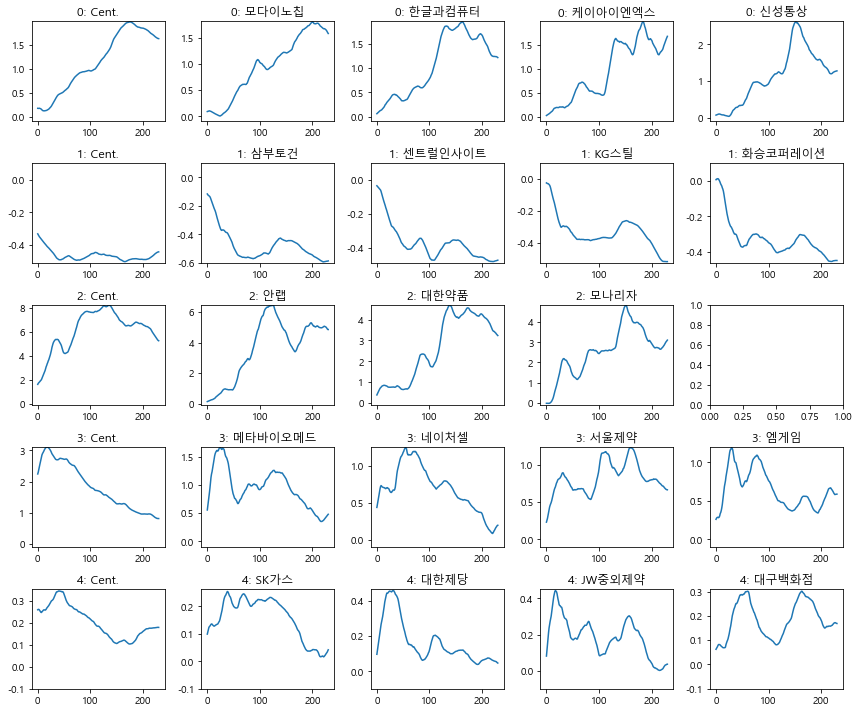

클러스터 간 (주가패턴 간) 상관관계
          0         1         2         3         4
0  1.000000 -0.590747  0.629207 -0.957978 -0.886371
1 -0.590747  1.000000 -0.633830  0.417992  0.265439
2  0.629207 -0.633830  1.000000 -0.609062 -0.592755
3 -0.957978  0.417992 -0.609062  1.000000  0.872064
4 -0.886371  0.265439 -0.592755  0.872064  1.000000


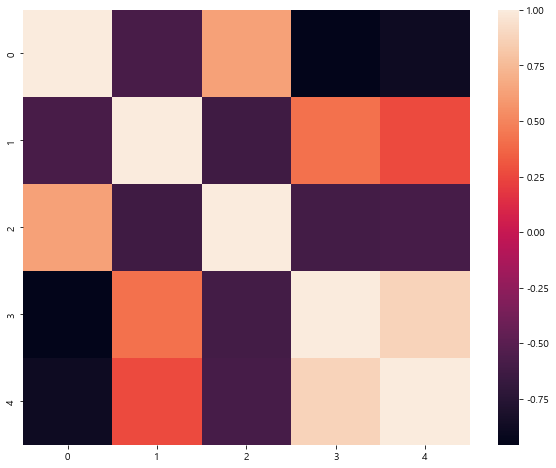

In [7]:
def get_silhouette_results(X, labels):
    def get_sum_distance(target_x, target_cluster):
        res = np.sum([np.linalg.norm(target_x-x) for x in target_cluster])
        return res
    
    '''
    각 데이터 포인트를 돌면서 a(i), b(i)를 계산
    그리고 s(i)를 계산한다.
    
    마지막으로 Silhouette(실루엣) Coefficient를 계산한다.
    '''
    uniq_labels = np.unique(labels)
    silhouette_val_list = []
    for i in range(len(labels)):
        target_data = X[i]

        ## calculate a(i)
        target_label = labels[i]
        target_cluster_data_idx = np.where(labels==target_label)[0]
        if len(target_cluster_data_idx) == 1:
            silhouette_val_list.append(0)
            continue
        else:
            target_cluster_data = X[target_cluster_data_idx]
            temp1 = get_sum_distance(target_data, target_cluster_data)
            a_i = temp1/(target_cluster_data.shape[0]-1)

        ## calculate b(i)
        b_i_list = []
        label_list = uniq_labels[np.unique(labels) != target_label]
        for ll in label_list:
            other_cluster_data_idx = np.where(labels==ll)[0]
            other_cluster_data = X[other_cluster_data_idx]
            temp2 = get_sum_distance(target_data, other_cluster_data)
            temp_b_i = temp2/other_cluster_data.shape[0]
            b_i_list.append(temp_b_i)

        b_i = min(b_i_list)
        s_i = (b_i-a_i)/max(a_i, b_i)
        silhouette_val_list.append(s_i)

    silhouette_coef_list = []
    
    for ul in uniq_labels:
        temp3 = np.mean([s for s, l in zip(silhouette_val_list, labels) if l == ul])
        silhouette_coef_list.append(temp3)

    silhouette_coef = max(silhouette_coef_list)
    return (silhouette_coef, np.array(silhouette_val_list))





# 파일 경로와 이름 변서 선언
file_path = './datasets/500_/ipynb/'
_json_file_name = 'names_'
_df1 = '_close_500'
_df2 = 'close_clu'

json_ext = '.json'
csv_ext = '.csv'

# for문 범위 설정을 위한 변수 선언
year_from = 2011
year_to = 2012
for _year in range(year_from, year_to):
    year = str(_year)
    codes = file_path + _json_file_name + year + json_ext
    df1 = file_path + year + _df1 + csv_ext
    df2 = file_path + year + _df2 + csv_ext

    # PBR + GPA 500위 종목 데이터프레임 읽어오기 (순위 데이터)
    df1 = pd.read_csv(df1, index_col=0)
    # index로 받아온 code의 데이터타입을 'str'로 변경하고, 
    df1.index = df1.index.astype('str').str.zfill(6)
    # df= pd.DataFrame(df['2011'], index=df1.index)+
    df1.reset_index(inplace=True)
    df1.rename(columns = {'index':'code'}, inplace=True)
    df1.drop([year + '_x', year + '_y','pbr_rank', 'gpa_rank','total_rank'], axis=1, inplace=True) 
    # 200위 종목까지만 남기기 위해 tail 이용하여 drop
    # df1.drop(df1.tail(299).index,inplace=True)
    
    with open(codes, 'r', encoding='utf-8') as f:
        codes = json.load(f) # 종목코드 불러오기 

    # 주가데이터 불러오기
    df2 = pd.read_csv(df2, dtype={'code': str}, index_col=0)
    # 200위 종목코드와 주가데이터의 종목코드 inner join
    df = pd.merge(df1, df2,how='inner', on='code')  # 



    # 일일주가 데이터에서 클러스터링에 필요한 벡터 추출한다.
    X = []
    names = []
    w = 20 # 이동평균기간(ex.20일 평균)
    n = (len(df[df.code == df.iloc[1]['code']])-w) + w  # 해당 주식의 총기간(ex. 각 종목당 139일 주가데이터가 있다.)
    for code_item in tqdm(codes):
        code = code_item['code'] # 코드 불러온다
        _df = df[df['code'] == code].dropna() # 주가데이터에서 불러온 코드에 결측치가 있으면 제거한다.
        if len(_df) < n: # 데이터 프레임의 길이가 n보다 작으면 다음 단계로 넘어간다.
            continue
        _df = _df.sort_values(by='date', ascending=True) # 데이터 프레임을 날짜기준 오름차순 정렬한다.(과거->현재)
        _df['x'] = _df['close'] / _df.iloc[0]['close'] - 1 # 초기값 대비 수익률을 구한다.
        _df = _df.dropna() # 결측치 제거한다.
        if len(_df) < n: # 데이터 프레임의 길이가 n보다 작으면 다음 단계로 넘어간다.
            continue
        _df['x'] = pd.Series(_df['x']).rolling(w).mean() #  수익률의 w일 이동평균을 구한다.
        X.append(_df['x'].tolist()[w-1:]) # w일 이동평균 값을 리스트화 한다.
        names.append(code_item['name']) # 종목명 리스트를 만든다.
    X = np.array(X) # 이동평균값 배열을 만든다.
    names = np.array(names) # 종목명 배열을 만든다.

    # X : 2320종목의 각 종목 당 120일 동안의 20일 이동평균
    # names : 2300종목의 종목명

    # 0~500겂 사이의 R값으로 s 값이 최대인거를 찾기

    
    k = 5
    s = []

    # # for count in range(4,6):
    # for rcount in range(0, 150+1):
    #     model = KMeans(n_clusters= k, random_state= rcount).fit(StandardScaler().fit_transform(X))
    #     silhouette_coef, silhouette_val_list = get_silhouette_results(X, model.labels_)
    #     # if silhouette_coef <= 0.3:
    #     #     continue
    #     # else:
    #     s.append(silhouette_coef)
    # Max_s = max(s)

    model = KMeans(n_clusters= k, random_state= 1).fit(StandardScaler().fit_transform(X))
    silhouette_coef, silhouette_val_list = get_silhouette_results(X, model.labels_)
  
        
    # MAX_silhouette = max(s)

    # print('연도 : ' + year)
    # print(MAX_silhouette)
    # model.cluster_centers : 클러스터를 특정할 벡터(중심점)
    # model.labels_ : 클러스터의 번호
    # fit_transform(X) : 2320종목의 120일 데이터를 KMeans에 사용하기 알맞게 변형한다.

    # StandardScaler : X를 정규화 한다.
    # KMeans.fit : X 데이터(2320개)를 가지고 k = 20개의 중심점을 찾아가는 훈련을 한다.



    # 클러스터 개수를 설정하고 KMeans 라이브러리를 호출한다.
    
    


    # 한글 폰트 가져오기(Window용)
    fm.get_fontconfig_fonts()
    font_location = 'C:\\Windows\\Fonts\\MALGUN.TTF'

    font_name = fm.FontProperties(fname=font_location).get_name()
    matplotlib.rc('font', family=font_name)
    matplotlib.rc('axes', unicode_minus=False)

    # 한극 폰트 가져오기(Mac용)
    # matplotlib.rcParams['font.family'] = 'AppleGothic'
    # matplotlib.rcParams['axes.unicode_minus'] = False

        # 클러스터 결과 시각화 함수
    def plot_clusters(model, k): # model = 사용할 분류모델(kmeans), k = 클러스터 개수
        
        # subplot '1번 컬럼' 부분 시각화
        c = 4
        fig, axes = plt.subplots(nrows=k, ncols=c+1, figsize=(c*3, k*2))
        for label in range(k): # 기준이 되는 클러스터 지정(k개), 첫 번째 컬럼 그래프 그리기, 학습된 클러스터 중심점
            x = model.cluster_centers_[label] # x = 클러스터 센터 / model.cluster_centers : 클러스터를 특정할 벡터(중심점)
            axes[label][0].plot(np.arange(len(x)), x) # x축 - 길이:120, y축 - 클러스터를 특정하는 벡터(중심점)
            axes[label][0].set_title(f'{label}: Cent.') # 타이틀
            axes[label][0].set_ylim([min(x.min() - 0.01, -0.1), max(x.max() + 0.01, 0.1)]) # y축 범위 지정

            # 2번  ~ 6번 컬럼 시각화
            n = 0
            _X = X[model.labels_ == label] # model.labels_ : 클러스터의 번호 / label = 클러스터 번호
            _names = names[model.labels_ == label] # 클러스터 번호에 해당하는 종목가져 불러오기
            dists = [euclidean(x, _x) for _x in _X] # 클러스터의 중심( x = model.cluster_centers_)과 X 데이터 간의 'Euclidean'거리 구하기
            idxs = np.argsort(dists)[:c] # argsort 배열을 오름차순으로 정렬하는 함수
            for x, name in zip(_X[idxs], _names[idxs]): # 각 클러스터에 해당하는 종목들 시각화 
                n += 1
                axes[label][n].plot(np.arange(len(x)), x) # x축 - 길이:120, y축 - 클러스터를 특정하는 벡터(중심점)
                axes[label][n].set_title(f'{label}: {name}') # 타이틀
                axes[label][n].set_ylim([min(x.min() - 0.01, -0.1), max(x.max() + 0.01, 0.1)]) # y축 범위 지정
                if n >= c:
                    break
        plt.tight_layout()
        plt.show()
    
    
    c = pd.DataFrame(model.cluster_centers_).T
    corr = c.corr()

    
    print('연도 : ' + year)
    

    print(silhouette_coef)
    print(Counter(model.labels_)) # 총 2320종목 중, {클러스터8 : 410종목, 클러스터3 : 295종목, 클러스터19 : 188종목 ... 클러스터14: 23종목, 클러스터18 : 19종목}
    plot_clusters(model, k) # 클러스터 결과 시각화, 20개 클러스터(row)중 학습된 클러스터 중심(1열)과 각 클러스터와 주가 움직임이 비슷한 종목 최초 5개(2열-6열) 시각화
    print('클러스터 간 (주가패턴 간) 상관관계')
    print(corr)
    fig = plt.figure(figsize=(10,8))
    sns.heatmap(corr)

In [8]:
pbr_df = magicstock.readcsv('./datasets/total_PBR.csv')  
gpa_df = magicstock.readcsv('./datasets/total_GPA.csv')
price_df = magicstock.price('./datasets/close_price_total.csv')

In [9]:
# 마법공식 적용해서 rank 추출하는 함수
magic = magicstock.magic_formula(gpa_df, pbr_df, '2011') # 년도 
magic   

,2011_x,2011_y,pbr_rank,gpa_rank,total_rank
011080,0.26,0.775991,54.0,58.0,1.0
033340,0.27,0.612703,59.5,102.0,2.0
009270,0.37,0.580091,169.5,108.0,3.0
038950,0.35,0.512416,144.0,134.0,4.0
002720,0.36,0.464839,154.5,163.0,5.0
...,...,...,...,...,...
032980,2.75,-0.011654,1548.5,1488.0,1362.0
069110,6.22,0.024698,1670.0,1434.0,1363.0
012170,6.72,0.014348,1674.0,1464.0,1364.0
074430,5.83,0.004701,1667.0,1478.0,1365.0


In [10]:
def plus_name(magic):
    corp = []
    for code in magic.index:
        name = stock.get_market_ticker_name(code) # 코스피, 코스닥 데이터의 종목명 데이터
        corp.append(name)
    magic['종목명'] = corp
    return magic

In [11]:
magic = magicstock.plus_name(magic)

# 클러스터별 마법공식 순위 확인하기
clu_11_1 = names[model.labels_ == 0]
clu_11_2 = names[model.labels_ == 1]
clu_11_3 = names[model.labels_ == 2]
clu_11_4 = names[model.labels_ == 3]
clu_11_5 = names[model.labels_ == 4]

c1 = magic.loc[magic.종목명.isin(clu_11_1)]
c2 = magic.loc[magic.종목명.isin(clu_11_2)]
c3 = magic.loc[magic.종목명.isin(clu_11_3)]
c4 = magic.loc[magic.종목명.isin(clu_11_4)]
c5 = magic.loc[magic.종목명.isin(clu_11_5)]


In [25]:
c3

,2011_x,2011_y,pbr_rank,gpa_rank,total_rank,종목명
012690,0.80,0.417612,747.5,202.0,121.0,모나리자
023910,0.67,0.289815,590.0,373.0,123.5,대한약품
053800,1.17,0.397334,1071.5,219.0,320.0,안랩


In [12]:
df_ = pd.concat([c1,c2,c3,c4,c5])

In [13]:
df_.to_csv("2014_list_.csv",encoding='cp949',index = True)


In [20]:
df_['종목명']

500

In [23]:
df_.sort_values('total_rank')

,2011_x,2011_y,pbr_rank,gpa_rank,total_rank,종목명
011080,0.26,0.775991,54.0,58.0,1.0,형지I&C
033340,0.27,0.612703,59.5,102.0,2.0,좋은사람들
009270,0.37,0.580091,169.5,108.0,3.0,신원
038950,0.35,0.512416,144.0,134.0,4.0,파인디지털
002720,0.36,0.464839,154.5,163.0,5.0,국제약품
...,...,...,...,...,...,...
001940,0.23,0.025656,39.0,1433.0,511.0,KISCO홀딩스
023150,0.48,0.095880,317.5,1155.0,513.0,MH에탄올
003280,0.49,0.099404,335.5,1140.0,516.0,흥아해운
036690,0.90,0.204361,847.5,628.0,516.0,코맥스
